In [ ]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import multiprocessing

In [ ]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

In [ ]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if mean_list.mean() < 0:
        return None
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return None
    return RAD_id

In [ ]:
pool = multiprocessing.Pool()
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# map(check_RAD_id, raw_RAD_id_list[:100])
# print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = list(pool.map(check_RAD_id, raw_RAD_id_list))
RAD_id_list = [x for x in RAD_id_list if x is not None]
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

In [ ]:
class myGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

In [ ]:
# tf.reset_default_graph()

save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# # Data files
# train_file = os.path.join(DATA_DIR, 'X_train.hkl')
# train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
# val_file = os.path.join(DATA_DIR, 'X_val.hkl')
# val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = None  # 100  number of sequences to use for validation

# Model parameters
image_size = 256
nt = 3  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 24, 48)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
layer_loss_weights = np.array([1., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu',
                  error_activation='elu', LSTM_inner_activation='sigmoid',
                  output_mode='prediction', return_sequences=False)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
    w = tf.add(y_true, tf.constant(0.8))
    w = tf.add(y_pred, w)
    loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(100000.0))
    return loss

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

In [ ]:
model.summary()

how to use tensorboard
```bash
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.1.115
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
```
`http://192.168.1.115:6006/#scalars&run=.&_smoothingWeight=0.8`

In [ ]:
lr_schedule = lambda epoch: 0.003 if epoch < 75 else 0.001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = myGenerator(list_IDs=RAD_id_list[:10], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
valid_generator = myGenerator(list_IDs=RAD_id_list[-10:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=1000, validation_data=valid_generator, validation_steps=2 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = myGenerator(list_IDs=RAD_id_list[:4500], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
valid_generator = myGenerator(list_IDs=RAD_id_list[4500:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=2)
history = model.fit_generator(train_generator, steps_per_epoch=300, epochs=5000, validation_data=valid_generator, validation_steps=2, callbacks=callbacks)

In [ ]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
y = model.predict(x)

In [ ]:
plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
history.history

In [ ]:
RAD_id = RAD_id_list[3]
x_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, nt, image_size, image_size, 1))
y_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 10)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, nt, image_size, image_size, 1))

In [ ]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [ ]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

In [ ]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

In [ ]:
%lsmagic

In [ ]:
%quickref

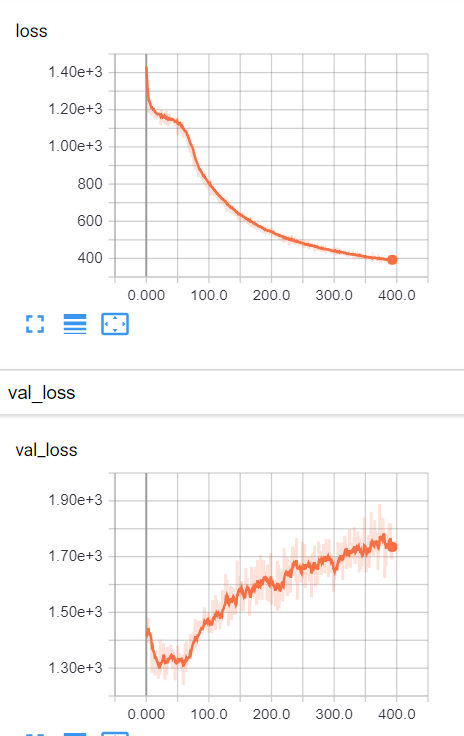
```
nt = 3
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
mean_list.mean() < 3
```
`420/420`